# Check alignment between simulations and inversions...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d, UnivariateSpline
from astropy.io import fits
from sklearn.cluster import KMeans

import sys
sys.path.append('/Users/kulkarniad/utils_rh/') # RH util functions
from rh import *

In [2]:
mu = 1.2904  # from rh
kb = 1.38064852*10.0**(-16.0) # cgs 
amu = 1.660540*10**(-24.0) # cgs 
g = 27400.0

NZ = 64
NY = 252
NX = 252
NLAMBDA = 257


In [3]:
# Load in observed spectrum
spectrum = np.loadtxt('/Users/kulkarniad/sir_inversions/2_line_run/spectrum.csv')
spectrum = spectrum.reshape((NLAMBDA,NY,NX))
# Inversion results

sir_temp = fits.open('inversion_files/sir_t.fits')[0].data
sir_vz = fits.open('inversion_files/sir_vlos.fits')[0].data
sir_p = fits.open('inversion_files/sir_p.fits')[0].data
sir_pe = fits.open('inversion_files/sir_pe.fits')[0].data
sir_rho = fits.open('inversion_files/sir_rho.fits')[0].data
sir_tau = np.load('inversion_files/tau_sir.npy')

# Throw away bottom of the atmosphere (stuff nan's out beyond log tau = 1.4)
cut_index = 6

sir_temp = sir_temp[:,:,cut_index:].transpose(2,1,0)
sir_vz = sir_vz[:,:,cut_index:].transpose(2,1,0) * (-1.0)
sir_p = sir_p[:,:,cut_index:].transpose(2,1,0) 
sir_pe = sir_pe[:,:,cut_index:].transpose(2,1,0) 
sir_rho = sir_rho[:,:,cut_index:].transpose(2,1,0) 
sir_tau = sir_tau[cut_index:] 

In [4]:
# Simulation results
sim = Atmos('simulation/muram_100.fits') # this is a Class

def readsim(file):
    raw = np.loadtxt(file)
    return raw.reshape((NZ,NY,NX))

sim_tau = np.log10(readsim('/Users/kulkarniad/sir_inversions/2_line_run/tau_100.csv')[1:,:,:])
sim_tau = np.append(np.zeros((1,NY,NX))-6.0,sim_tau,axis=0) ## append log tau = -6 a

# Everything is aligned and I'm using the convention that array dimensions are (NZ,NY,NX)

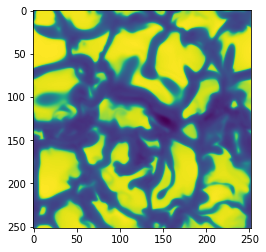

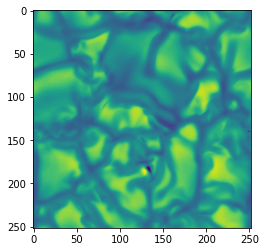

In [5]:
plt.imshow(sim.t[30])
plt.show()
plt.imshow(spectrum[30])
plt.show()


# Now do clustering

In [6]:
spectrum.shape

(257, 252, 252)

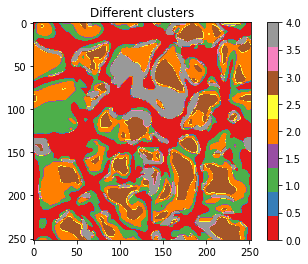

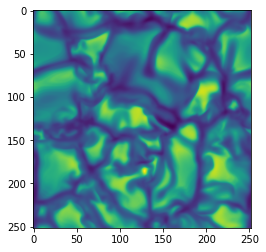

In [7]:
N_CLUSTERS = 5
kmeans_raw = KMeans(n_clusters=N_CLUSTERS,init = 'k-means++' , random_state=5)

kmeans_raw.fit(spectrum.reshape((NLAMBDA,NX*NY)).T)
cluster_labels = kmeans_raw.labels_.reshape((NY,NX))

plt.imshow(cluster_labels,cmap='Set1')
plt.colorbar()
plt.title('Different clusters')
plt.show()
plt.imshow(spectrum[0])
plt.show()

# Clusters are aligned with Spectrum

In [8]:
counts = np.zeros(N_CLUSTERS)

for i in range(N_CLUSTERS):
    counts[i] = np.count_nonzero(kmeans_raw.labels_.flatten() == i)

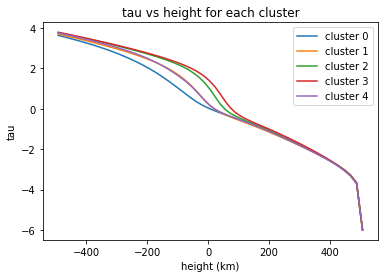

In [9]:
tau_clusters = np.zeros((N_CLUSTERS,NZ))
for j in range(NY):
    for i in range(NX):
        for c in range(N_CLUSTERS):
            if cluster_labels[j,i] == c:
                tau_clusters[c] += sim_tau[:,j,i]

# divide by number of pixels in each class and plot:
for c in range(N_CLUSTERS):
    tau_clusters[c] /= counts[c]
    plt.plot(sim.z,tau_clusters[c],label = 'cluster ' + str(c))

plt.legend()
plt.xlabel('height (km)')
plt.ylabel('tau')
plt.title('tau vs height for each cluster')
plt.show()

In [10]:
# create interpolating functions for tau(z)
tau_z = []
for c in range(N_CLUSTERS):
    function = interp1d(sim.z,tau_clusters[c],kind='linear',fill_value='extrapolate')
    tau_z.append(function)

In [11]:
#CHECK SIMULATION CODE

# recons_temp = np.zeros((NZ,NY,NX))  
# recons_vz = np.zeros((NZ,NY,NX)) 
# recons_vy = np.zeros((NZ,NY,NX))   
# recons_vx = np.zeros((NZ,NY,NX))   
# recons_nelec = np.zeros((NZ,NY,NX))  
# recons_nh = np.zeros((NZ,NY,NX))  

# for j in range(NY):
#     for i in range(NX):
#         temp_tau = interp1d(sim_tau[:,j,i],sim.t[:,j,i]) 
#         vz_tau = interp1d(sim_tau[:,j,i],sim.vz[:,j,i]) 
#         vy_tau = interp1d(sim_tau[:,j,i],sim.vy[:,j,i])
#         vx_tau = interp1d(sim_tau[:,j,i],sim.vx[:,j,i])
#         nelec_tau = interp1d(sim_tau[:,j,i],sim.nelec[:,j,i])
#         nh_tau = interp1d(sim_tau[:,j,i],sim.nh[:,j,i])

#         recons_temp[:,j,i] = temp_tau(sim_tau[:,j,i])
#         recons_vz[:,j,i] = vz_tau(sim_tau[:,j,i])
#         recons_vy[:,j,i] = vy_tau(sim_tau[:,j,i])
#         recons_vx[:,j,i] = vx_tau(sim_tau[:,j,i])
#         recons_nelec[:,j,i] = nelec_tau(sim_tau[:,j,i])
#         recons_nh[:,j,i] = nh_tau(sim_tau[:,j,i])
                
# # smoothing and cutout

# # smoothing = 3

# # recons_temp = gaussian_filter(recons_temp,(0,smoothing,smoothing))

# # recons_vz = gaussian_filter(recons_vz,(0,smoothing,smoothing))
# # recons_vy = gaussian_filter(recons_vy,(0,smoothing,smoothing))
# # recons_vx = gaussian_filter(recons_vx,(0,smoothing,smoothing))

# # recons_nelec = gaussian_filter(recons_nelec,(0,smoothing,smoothing))
# # recons_nh = gaussian_filter(recons_nh,(0,smoothing,smoothing))

# cutout = 50

# recons_temp = recons_temp[:,0:cutout,0:cutout]
# recons_vz = recons_vz[:,0:cutout,0:cutout]
# recons_vy = recons_vy[:,0:cutout,0:cutout]
# recons_vx = recons_vx[:,0:cutout,0:cutout]
# recons_nelec = recons_nelec[:,0:cutout,0:cutout]
# recons_nh = recons_nh[:,0:cutout,0:cutout]

In [12]:
# recons_temp = np.zeros((NZ,NY,NX))  
# recons_vz = np.zeros((NZ,NY,NX)) 
# recons_vy = np.zeros((NZ,NY,NX))   
# recons_vx = np.zeros((NZ,NY,NX))   
# recons_nelec = np.zeros((NZ,NY,NX))  
# recons_nh = np.zeros((NZ,NY,NX))  

# for j in range(NY):
#     for i in range(NX):
#         temp_tau = interp1d(sim_tau[:,j,i],sim.t[:,j,i],fill_value='extrapolate') 
#         vz_tau = interp1d(sim_tau[:,j,i],sim.vz[:,j,i],fill_value='extrapolate') 
#         vy_tau = interp1d(sim_tau[:,j,i],sim.vy[:,j,i],fill_value='extrapolate')
#         vx_tau = interp1d(sim_tau[:,j,i],sim.vx[:,j,i],fill_value='extrapolate')
#         nelec_tau = interp1d(sim_tau[:,j,i],sim.nelec[:,j,i],fill_value='extrapolate')
#         nh_tau = interp1d(sim_tau[:,j,i],sim.nh[:,j,i],fill_value='extrapolate')

#         for c in range(N_CLUSTERS):
#             if cluster_labels[j,i] == c:
#                 recons_temp[:,j,i] = temp_tau(tau_z[c](sim.z))
#                 recons_vz[:,j,i] = vz_tau(tau_z[c](sim.z))
#                 recons_vy[:,j,i] = vy_tau(tau_z[c](sim.z))
#                 recons_vx[:,j,i] = vx_tau(tau_z[c](sim.z))
#                 recons_nelec[:,j,i] = nelec_tau(tau_z[c](sim.z))
#                 recons_nh[:,j,i] = nh_tau(tau_z[c](sim.z))
                
# # smoothing and cutout

# smoothing = 3

# recons_temp = gaussian_filter(recons_temp,(0,smoothing,smoothing))

# recons_vz = gaussian_filter(recons_vz,(0,smoothing,smoothing))
# recons_vy = gaussian_filter(recons_vy,(0,smoothing,smoothing))
# recons_vx = gaussian_filter(recons_vx,(0,smoothing,smoothing))

# recons_nelec = gaussian_filter(recons_nelec,(0,smoothing,smoothing))
# recons_nh = gaussian_filter(recons_nh,(0,smoothing,smoothing))

# cutout = 50

# recons_temp = recons_temp[:,0:cutout,0:cutout]
# recons_vz = recons_vz[:,0:cutout,0:cutout]
# recons_vy = recons_vz[:,0:cutout,0:cutout]
# recons_vx = recons_vz[:,0:cutout,0:cutout]
# recons_nelec = recons_nelec[:,0:cutout,0:cutout]
# recons_nh = recons_nh[:,0:cutout,0:cutout]

In [14]:
# FUll reconstruction
recons_temp = np.zeros((NZ,NY,NX))  
recons_vz = np.zeros((NZ,NY,NX))   
recons_p = np.zeros((NZ,NY,NX))  
recons_pe = np.zeros((NZ,NY,NX))  
recons_rho = np.zeros((NZ,NY,NX))   

for j in range(NY):
    for i in range(NX):
        temp_tau = interp1d(sir_tau,sir_temp[:,j,i],fill_value='extrapolate') 
        vz_tau = interp1d(sir_tau,sir_vz[:,j,i],fill_value='extrapolate') 
        p_tau = interp1d(sir_tau,sir_p[:,j,i],fill_value='extrapolate')
        pe_tau = interp1d(sir_tau,sir_pe[:,j,i],fill_value='extrapolate')
        rho_tau = interp1d(sir_tau,sir_rho[:,j,i],fill_value='extrapolate')

        for c in range(N_CLUSTERS):
            if cluster_labels[j,i] == c:
                recons_temp[:,j,i] = temp_tau(tau_z[c](sim.z))
                recons_vz[:,j,i] = vz_tau(tau_z[c](sim.z))
                recons_p[:,j,i] = p_tau(tau_z[c](sim.z))
                recons_pe[:,j,i] = pe_tau(tau_z[c](sim.z))
                recons_rho[:,j,i] = rho_tau(tau_z[c](sim.z))

#Calculate derived quantites and put into RH units:

recons_nh = recons_rho/(mu*amu)*(1e6)
recons_vz = recons_vz*(1e-5)
recons_nelec = recons_pe/(recons_temp*kb)*(1e6)


#set thresholds

recons_temp[recons_temp < 4500.0] = 4500.0
recons_temp[recons_temp > 15000.0] = 15000.0

recons_nh[recons_nh < 1e21] =  1e21
recons_nh[recons_nh > 1e23] =  1e23

recons_nelec[recons_nelec < 1e17] =  1e17
recons_nelec[recons_nelec > 1e23] =  1e23

recons_vz[recons_vz < -15.0] =  -15.0
recons_vz[recons_vz > 15.0] =  15.0

# Apply a horizontal gaussian filter in the atmosphere:


smth = 3

recons_temp = gaussian_filter(recons_temp,(0,smth,smth))
recons_vz = gaussian_filter(recons_vz,(0,smth,smth))
recons_nelec = gaussian_filter(recons_nelec,(0,smth,smth))
recons_nh = gaussian_filter(recons_nh,(0,smth,smth))

#cutout = 50
#recons_temp = recons_temp[:,0:cutout,0:cutout]
#recons_vz = recons_vz[:,0:cutout,0:cutout]
#recons_nelec = recons_nelec[:,0:cutout,0:cutout]
#recons_nh = recons_nh[:,0:cutout,0:cutout]

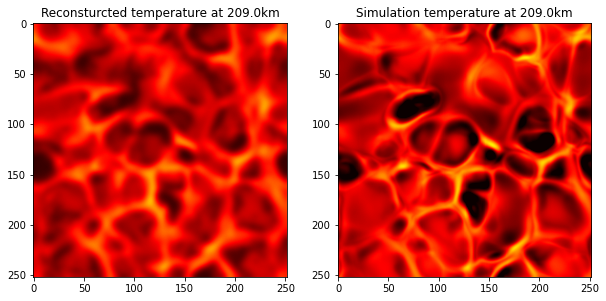

In [35]:
sim_atmos = fits.open('simulation/muram_100.fits')[1].data[0]
k = 16
z = str(round(sim.z[k],2)) + 'km'
plt.figure(figsize=(10,7))
plt.subplot(121)
plt.title('Reconsturcted temperature at '+z)
plt.imshow(recons_temp[15,:,:],cmap='hot')
plt.clim(4400,6000)
plt.subplot(122)
plt.title('Simulation temperature at '+z)
plt.imshow(sim_atmos[8][15,:,:],cmap='hot')
plt.clim(4400,6000)
plt.show()

In [177]:
# WRITE RECONSTRUCTION


sim_atmos = fits.open('simulation/muram_100.fits')[1].data[0]

NHydr = 1
nx = 50
ny = 50
nz = 64

dx = sim_atmos[5]  
dy = sim_atmos[6]

z_vals = sim_atmos[7]

BcIrradiated = 0
BcZero = 1
BcThermalised = 2

upperBc = BcZero
lowerBc = BcThermalised

vmic = np.zeros((nz, ny, nx))
vx = np.zeros((nz, ny, nx))
vy = np.zeros((nz, ny, nx))



# NOTE(cmo): Pack the data into an xdrlib Packer
p = xdrlib.Packer()
p.pack_int(nx)
p.pack_int(ny)
p.pack_int(nz)
p.pack_int(NHydr)
p.pack_int(upperBc)
p.pack_int(lowerBc)

p.pack_double(dx)
p.pack_double(dy)

p.pack_farray(nz, z_vals, p.pack_double)
p.pack_farray(nz*ny*nx, recons_temp.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, recons_nelec.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, vmic.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, sim_atmos[11][:,:ny,:nx].flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, sim_atmos[12][:,:ny,:nx].flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, recons_vz.flatten(), p.pack_double)
p.pack_farray(NHydr*nz*ny*nx,recons_nh.flatten(), p.pack_double)

! rm 'reconstruct_horizonvel.atmos'
# NOTE(cmo): Dump the packer's data into a binary file
with open('reconstruct_horizonvel.atmos', 'wb') as f:
    f.write(p.get_buffer()) 

rm: reconstruct_horizonvel.atmos: No such file or directory


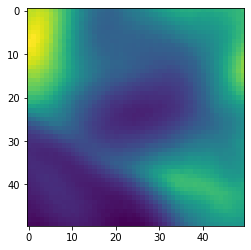

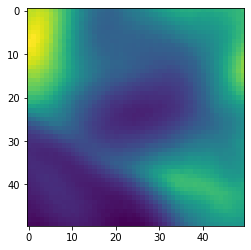

In [159]:
plt.imshow(recons_temp[1,:50,:50])
plt.show()
plt.imshow(sim.t[1,:50,:50])

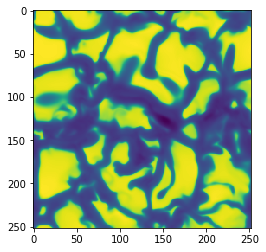

In [44]:
plt.imshow(sim_atmos[8][30])

In [108]:
# WRITE MURAM ATMOS


sim_atmos = fits.open('simulation/muram_100.fits')[1].data[0]

NHydr = 1
nx = 50
ny = 50
nz = 64

dx = sim_atmos[5]  
dy = sim_atmos[6]

z_vals = sim_atmos[7]

BcIrradiated = 0
BcZero = 1
BcThermalised = 2

upperBc = BcZero
lowerBc = BcThermalised

vmic = np.zeros((nz, ny, nx))


# NOTE(cmo): Pack the data into an xdrlib Packer
p = xdrlib.Packer()
p.pack_int(nx)
p.pack_int(ny)
p.pack_int(nz)
p.pack_int(NHydr)
p.pack_int(upperBc)
p.pack_int(lowerBc)

p.pack_double(dx)
p.pack_double(dy)

p.pack_farray(nz, z_vals, p.pack_double)
p.pack_farray(nz*ny*nx, sim_atmos[8][:,:ny,:nx].flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, sim_atmos[9][:,:ny,:nx].flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, vmic.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, sim_atmos[11][:,:ny,:nx].flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, sim_atmos[12][:,:ny,:nx].flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, sim_atmos[13][:,:ny,:nx].flatten(), p.pack_double)
p.pack_farray(NHydr*nz*ny*nx,sim_atmos[14][:,:ny,:nx].flatten(), p.pack_double)

! rm 'new_small.atmos'
# NOTE(cmo): Dump the packer's data into a binary file
with open('new_small.atmos', 'wb') as f:
    f.write(p.get_buffer()) 
    

In [112]:
# WRITE MURAM ATMOS


sim_atmos = fits.open('simulation/muram_100.fits')[1].data[0]

NHydr = 1
nx = 50
ny = 50
nz = 64

dx = sim_atmos[5]  
dy = sim_atmos[6]

z_vals = sim_atmos[7]

BcIrradiated = 0
BcZero = 1
BcThermalised = 2

upperBc = BcZero
lowerBc = BcThermalised

vmic = np.zeros((nz, ny, nx))


# NOTE(cmo): Pack the data into an xdrlib Packer
p = xdrlib.Packer()
p.pack_int(nx)
p.pack_int(ny)
p.pack_int(nz)
p.pack_int(NHydr)
p.pack_int(upperBc)
p.pack_int(lowerBc)

p.pack_double(dx)
p.pack_double(dy)

p.pack_farray(nz, z_vals, p.pack_double)
p.pack_farray(nz*ny*nx, sim_atmos[8][:,:ny,:nx].flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, sim_atmos[9][:,:ny,:nx].flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, vmic.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, vmic.flatten(), p.pack_double) #vx = 0
p.pack_farray(nz*ny*nx, vmic.flatten(), p.pack_double) #vy = 0
p.pack_farray(nz*ny*nx, sim_atmos[13][:,:ny,:nx].flatten(), p.pack_double)
p.pack_farray(NHydr*nz*ny*nx,sim_atmos[14][:,:ny,:nx].flatten(), p.pack_double)

! rm 'new_small_novel.atmos'
# NOTE(cmo): Dump the packer's data into a binary file
with open('new_small_novel.atmos', 'wb') as f:
    f.write(p.get_buffer()) 

rm: new_small_novel.atmos: No such file or directory


In [120]:
sim_atmos[13][:,:50,:50].shape

(64, 50, 50)

In [110]:
# WRITE RECONSTRUCTION


sim_atmos = fits.open('simulation/muram_100.fits')[1].data[0]

NHydr = 1
nx = 50
ny = 50
nz = 64

dx = sim_atmos[5]  
dy = sim_atmos[6]

z_vals = sim_atmos[7]

BcIrradiated = 0
BcZero = 1
BcThermalised = 2

upperBc = BcZero
lowerBc = BcThermalised

vmic = np.zeros((nz, ny, nx))


# NOTE(cmo): Pack the data into an xdrlib Packer
p = xdrlib.Packer()
p.pack_int(nx)
p.pack_int(ny)
p.pack_int(nz)
p.pack_int(NHydr)
p.pack_int(upperBc)
p.pack_int(lowerBc)

p.pack_double(dx)
p.pack_double(dy)

p.pack_farray(nz, z_vals, p.pack_double)
p.pack_farray(nz*ny*nx, recons_temp.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, recons_nelec.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, vmic.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, recons_vx.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, recons_vy.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, recons_vz.flatten(), p.pack_double)
p.pack_farray(NHydr*nz*ny*nx,recons_nh.flatten(), p.pack_double)

! rm 'code_test.atmos'
# NOTE(cmo): Dump the packer's data into a binary file
with open('code_test.atmos', 'wb') as f:
    f.write(p.get_buffer()) 

In [116]:
! diff new_small.atmos code_test.atmos

Binary files new_small.atmos and code_test.atmos differ


In [118]:
np.max(recons_temp - sim_atmos[8][:,:50,:50])

0.0

In [121]:
from scipy.ndimage import gaussian_filter

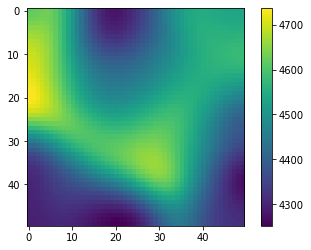

In [143]:
plt.imshow(gaussian_filter(recons_temp, (0,3,3))[5])
plt.colorbar()

In [144]:
# WRITE MURAM smooth


sim_atmos = fits.open('simulation/muram_100.fits')[1].data[0]

NHydr = 1
nx = 50
ny = 50
nz = 64

smth = 3
dx = sim_atmos[5]  
dy = sim_atmos[6]

z_vals = sim_atmos[7]

BcIrradiated = 0
BcZero = 1
BcThermalised = 2

upperBc = BcZero
lowerBc = BcThermalised

vmic = np.zeros((nz, ny, nx))


# NOTE(cmo): Pack the data into an xdrlib Packer
p = xdrlib.Packer()
p.pack_int(nx)
p.pack_int(ny)
p.pack_int(nz)
p.pack_int(NHydr)
p.pack_int(upperBc)
p.pack_int(lowerBc)

p.pack_double(dx)
p.pack_double(dy)

p.pack_farray(nz, z_vals, p.pack_double)
p.pack_farray(nz*ny*nx, gaussian_filter(sim_atmos[8], (0,smth,smth))[:,:ny,:nx].flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, gaussian_filter(sim_atmos[9], (0,smth,smth))[:,:ny,:nx].flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, vmic.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, gaussian_filter(sim_atmos[11], (0,smth,smth))[:,:ny,:nx].flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, gaussian_filter(sim_atmos[12], (0,smth,smth))[:,:ny,:nx].flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, gaussian_filter(sim_atmos[13], (0,smth,smth))[:,:ny,:nx].flatten(), p.pack_double)
p.pack_farray(NHydr*nz*ny*nx,gaussian_filter(sim_atmos[14], (0,smth,smth))[:,:ny,:nx].flatten(), p.pack_double)

! rm 'new_small_smth3.atmos'
# NOTE(cmo): Dump the packer's data into a binary file
with open('new_small_smth3.atmos', 'wb') as f:
    f.write(p.get_buffer()) 
    

rm: new_small_smth3.atmos: No such file or directory


Plan:

1) Make sure the interpolation is'nt going to cause a difference

2) See if the the smoothing causes a difference

3) See if vx = 0 and vy = 0 causes a difference

4) If things look good, try reconstruct w/ true temp/tau



In [146]:
vel = Rhout('/Users/kulkarniad/rh_aniso/rhsc3d/new_small')
novel = Rhout('/Users/kulkarniad/rh_aniso/rhsc3d/new_small_novel')

(WWW) read_atmos: no Stokes data in atmos.out, skipping.
(WWW) close_xdr: /Users/kulkarniad/rh_aniso/rhsc3d/new_small/spectrum.out not all data read!
(WWW) read_atmos: no Stokes data in atmos.out, skipping.
(WWW) close_xdr: /Users/kulkarniad/rh_aniso/rhsc3d/new_small_novel/spectrum.out not all data read!
